In [1]:
import pandas as pd
import warnings
import time
import matplotlib.pyplot as plt
from src.helper_methods import *
from src.pipe_store import *
warnings.filterwarnings('ignore')

# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Load Dataset

In [2]:
path_cohort = '~/UMCUtrecht/KaplanMeier/DESAsurvival.pickle'
path_antibody = '~/UMCUtrecht/20211104_mismatch_ep_db.pickle'
df_abs = pd.read_pickle(path_antibody)
df_cohort = pd.read_pickle(path_cohort)
df = df_abs.merge(df_cohort, on='TransplantID')
print(df.columns)
cols = [
    'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
    'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb',
    'CIPHour_DBD', 'CIPHour_DCD' , 'LivingDonorNum', # 'FailureCode10y'
]
df = df[cols]
df.columns

Index(['TransplantID', 'Epitope_Mismatch', 'DESA_Status', 'EpvsHLA_Donor',
       '#DESA', 'DESA', 'RecipientAge_NOTR', 'RecipientSex_NOTR',
       'DonorAge_NOTR', 'DonorSex_NOTR', 'Retransplant', 'TxYear', 'Center',
       'TypeOfDonor_NOTR', 'LivingDonorNum', 'GraftFunction_NOTR',
       'ColdIschaemicPeriod_NOTR', 'CIPHour', 'CIPHour_DBD', 'CIPHour_DCD',
       'CurrentPRA_NOTR', 'HighPRA_NOTR', 'IL2rMoAb', 'GraftSurvival10y',
       'GraftSurvival10Y_R', 'GraftSurvival1y', 'GraftSurvivalY1_R',
       'FailureCode10y', 'FailureCode10Y_R', 'FailureCode1Y_R',
       'FailureCode1y', 'RejectionCodeY10_R', 'PatientSurvival10Y',
       'PatientDeathCode10Y', 'GraftSurvival3m', 'FailureCode3m'],
      dtype='object')


Index(['TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA',
       'RecipientAge_NOTR', 'DonorAge_NOTR', 'TypeOfDonor_NOTR',
       'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb', 'CIPHour_DBD',
       'CIPHour_DCD', 'LivingDonorNum'],
      dtype='object')

# Finding relevant DESA using Automation

In [3]:
from src.pipe_store import df_inv_val_split
from src.helper_methods import  kaplan_meier_curves_automation, plot_kaplan_meier_curve_automation
from collections import  defaultdict
from time import time
# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def inv_val_split(df, val_size:float, donor_type='Deceased'):
    df_dead = df[df.TypeOfDonor_NOTR == donor_type]
    msk = np.random.rand(len(df_dead)) < val_size
    return (df_dead[~msk], df_dead[msk])

def cross_val_split(df, k_fold:int, donor_type='Deceased'):
    df_type = df[df.TypeOfDonor_NOTR == donor_type]
    df_type = df_type.sample(frac=1).reset_index(drop=True) # shuffle dataframe
    fold_samples = len(df_type) // k_fold + 1
    return [df_type.loc[(i-1) * fold_samples: i * fold_samples] for i in range(1, 6)]

def summerize_results(df_res, iter, add_val_res):
    freq_inv = [f'freq_iter_{i}'  for i in range(1, iter + 1)]
    avg_diff_early = [f'avg_diff_early_inv_iter_{i}' for i in range(1, iter + 1)]
    avg_diff_mid = [f'avg_diff_mid_inv_iter_{i}' for i in range(1, iter + 1)]
    avg_diff_late = [f'avg_diff_late_inv_iter_{i}' for i in range(1, iter + 1)]
    p_value_inv = [f'p_value_inv_iter_{i}' for i in range(1, iter + 1)]

    df_sum = pd.DataFrame()
    df_sum['epitope'] = df_res['epitope']
    df_sum['freq_inv'] = df_res[freq_inv].mean(axis=1)
    df_sum['#sig_p_value_inv'] = df_res[p_value_inv].apply(lambda x: len([p_val for p_val in x if p_val < 0.05]), axis=1)
    df_sum['avg_diff_early_inv'] = df_res[avg_diff_early].mean(axis=1)
    df_sum['avg_diff_mid_inv'] = df_res[avg_diff_mid].mean(axis=1)
    df_sum['avg_diff_late_inv'] = df_res[avg_diff_late].mean(axis=1)
    
    if add_val_res:
        freq_val = [f'freq_val_iter_{i}'  for i in range(1, iter + 1)]
        avg_diff_early_val = [f'avg_diff_early_val_iter_{i}' for i in range(1, iter + 1)]
        avg_diff_mid_val = [f'avg_diff_mid_val_iter_{i}' for i in range(1, iter + 1)]
        avg_diff_late_val = [f'avg_diff_late_val_iter_{i}' for i in range(1, iter + 1)]
        p_value_val = [f'p_value_val_iter_{i}' for i in range(1, iter + 1)]

        df_sum['freq_val'] = df_res[freq_val].mean(axis=1)
        df_sum['#sig_p_value_val'] = df_res[p_value_val].apply(lambda x: len([p_val for p_val in x if p_val < 0.05]), axis=1)
        df_sum['avg_diff_early_val'] = df_res[avg_diff_early_val].mean(axis=1)
        df_sum['avg_diff_mid_val'] = df_res[avg_diff_mid_val].mean(axis=1)
        df_sum['avg_diff_late_val'] = df_res[avg_diff_late_val].mean(axis=1)
    return df_sum

def epitope_relevance_validation(df, iter:int, ep_freq_inv:int, ep_freq_val:int, val_size:int, add_val_res:bool=False):
    collect_res = defaultdict(dict)

    confounders = [
        'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
        'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
        'CIPHour_DBD', 'CIPHour_DCD', 
    ]
    treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
    for i in range(1, iter + 1):
        now = time()
        df_inv, df_val = inv_val_split(df, val_size=val_size, donor_type='Deceased')
        list_set_desa = df_inv[df_inv.DESA_Status == 'DESA'].DESA.values
        epitopes = {ep for desa_set in list_set_desa for ep in desa_set}
        for ep in epitopes:
            freq_inv = df_inv.DESA.apply(lambda x: ep in x).sum()
            freq_val = df_val.DESA.apply(lambda x: ep in x).sum()
            if (freq_inv >= ep_freq_inv) & (freq_val >= ep_freq_val):
                try:
                    df_tret_group = create_treatment_grups(df_inv, [{ep}])
                    df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)
                    labels = ['Other_DESA', 'Specific_DESA']
                    kmfs, p_value_inv = kaplan_meier_curves_automation(df_weight, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
                except Exception as e:
                    print(f'Investigation Exception: {e} Epitope: {ep}')
                    continue
                km_rest, km_ep = kmfs[0], kmfs[1]
                diff = km_ep.survival_function_.values - km_rest.survival_function_.values
                collect_res[ep][f'freq_iter_{i}'] = int(freq_inv)
                collect_res[ep][f'avg_diff_early_inv_iter_{i}'] = diff[0:250].mean()
                collect_res[ep][f'avg_diff_mid_inv_iter_{i}'] = diff[250:650].mean()
                collect_res[ep][f'avg_diff_late_inv_iter_{i}'] = diff[650:].mean()
                collect_res[ep][f'avg_diff_inv_iter_{i}'] = diff.mean()
                collect_res[ep][f'p_value_inv_iter_{i}'] = p_value_inv
                if add_val_res:
                    try:
                        df_tret_group_val = create_treatment_grups(df_val, [{ep}])
                        df_weight_val = find_ipw(df_tret_group_val, confounders, treatments, verbose=False)
                        labels = ['Other_DESA', 'Specific_DESA']
                        kmfs_val, p_value_val = kaplan_meier_curves_automation(df_weight_val, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
                    except Exception as e:
                        print(f'Validation Exception: {e} Epitope: {ep}')
                    km_rest, km_ep = kmfs_val[0], kmfs_val[1]
                    diff_val = km_ep.survival_function_.values - km_rest.survival_function_.values

                    collect_res[ep][f'freq_val_iter_{i}'] = int(freq_val)
                    collect_res[ep][f'avg_diff_early_val_iter_{i}'] = diff_val[0:250].mean()
                    collect_res[ep][f'avg_diff_mid_val_iter_{i}'] = diff_val[250:650].mean()
                    collect_res[ep][f'avg_diff_late_val_iter_{i}'] = diff_val[650:].mean()
                    collect_res[ep][f'p_value_val_iter_{i}'] = p_value_val
                    collect_res[ep][f'avg_diff_val_iter_{i}'] = diff_val.mean()
        
        print(f'Iteration {i} is concluded in {time() - now} seconds')
    df_res = pd.DataFrame(collect_res).T.reset_index().rename(columns={'index':'epitope'})
    return summerize_results(df_res, iter, add_val_res), df_res

def plot_km_curve(df:pd.DataFrame, donor_type:str, ep:set, adjust:bool=False, num_curves:int=3):
    confounders = [
        'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
        'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
        'CIPHour_DBD', 'CIPHour_DCD', 
    ]

    treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
    ep = set(ep)
    labels = ['No DESA', 'Other DESA', 'Specific_DES']
    df_tret_group = create_treatment_grups(df, [ep])
    df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)
    if num_curves == 3:
        kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=ep, donor_type=donor_type, labels=labels, adjust=adjust)
    if num_curves == 2:
        kmfs, p_value = kaplan_meier_curves_automation(df_weight, desa_spec=ep, donor_type=donor_type, labels=labels, adjust=adjust)
    plot_kaplan_meier_curve(kmfs, p_value, verbose=True, title='')



In [21]:
df_filtered = df[(df.TypeOfDonor_NOTR == 'Deceased')]

res = [
    epitope_relevance_validation(df_filtered, iter=1, ep_freq_inv=2, ep_freq_val=2, val_size=0.3, add_val_res=True)
    for _ in range(100)
]

Iteration 1 is concluded in 28.80117392539978 seconds
Iteration 1 is concluded in 33.24733304977417 seconds
Iteration 1 is concluded in 26.03756809234619 seconds
Iteration 1 is concluded in 30.60661506652832 seconds
Iteration 1 is concluded in 27.270170211791992 seconds
Iteration 1 is concluded in 28.262916088104248 seconds
Iteration 1 is concluded in 29.720799207687378 seconds
Iteration 1 is concluded in 26.833304166793823 seconds
Iteration 1 is concluded in 29.132630109786987 seconds
Iteration 1 is concluded in 26.12139916419983 seconds
Iteration 1 is concluded in 24.604939937591553 seconds
Iteration 1 is concluded in 32.91599798202515 seconds
Iteration 1 is concluded in 23.762420415878296 seconds
Iteration 1 is concluded in 30.908555030822754 seconds
Iteration 1 is concluded in 28.01178503036499 seconds
Iteration 1 is concluded in 25.566953897476196 seconds
Iteration 1 is concluded in 31.537792921066284 seconds
Iteration 1 is concluded in 26.951301097869873 seconds
Iteration 1 is co

In [9]:
import pickle 

path = '/Users/Danial/Repos/STRIDE/desa_paper/data/results_final.pickle'

# save
# filehandler = open(path, 'wb') 
# pickle.dump(res, filehandler)
# load
fileObj = open(path, 'rb')
res = pickle.load(fileObj)

df_res, df_sum = [tup[1] for tup in res], [tup[0] for tup in res]

In [10]:
def analyse_results(df, threshold:float, val:bool, output:str, relevance:str):
    if val: # Both investigation & validation  
        if relevance == 'good':
            df_ep = df[(df.avg_diff_inv_iter_1 > threshold) & (df.avg_diff_val_iter_1 > threshold)]
        else: 
            df_ep = df[(df.avg_diff_inv_iter_1 < threshold) & (df.avg_diff_val_iter_1 < threshold)]
    else: # Only Investigation
        if relevance == 'good':
            df_ep = df[df.avg_diff_inv_iter_1 > threshold]
        else:
            df_ep = df[df.avg_diff_inv_iter_1 < threshold]

    
    return {'df': df_ep, 'epitope': set(df_ep.epitope.tolist())}.get(output)



In [35]:
def analyse_results_ext(dfs, threshold:float, val:bool, relevance:str, p_val=0.2):
    from collections import defaultdict, Counter
    from statistics import mean
    agg_dict = defaultdict(lambda: defaultdict(list))

    for df in dfs:
        if val: # Both investigation & validation  
            if relevance == 'good': # threshold should be positive
                df_ep = df[(df.avg_diff_inv_iter_1 > threshold) & (df.avg_diff_val_iter_1 > threshold)]
            else: # threshold should be negative
                df_ep = df[(df.avg_diff_inv_iter_1 < threshold) & (df.avg_diff_val_iter_1 < threshold)]
        else: # Only Investigation
            if relevance == 'good':  # threshold should be positive
                df_ep = df[df.avg_diff_inv_iter_1 > threshold]
            else: # threshold should be negative
                df_ep = df[df.avg_diff_inv_iter_1 < threshold]
        for ep in df_ep.epitope.unique():
            df_filt = df_ep[df_ep.epitope == ep]
            agg_dict[ep]['count'].append(1)
            agg_dict[ep]['freq_inv'].append(df_filt['freq_iter_1'].values[0])
            agg_dict[ep]['freq_val'].append(df_filt['freq_val_iter_1'].values[0])
            agg_dict[ep]['avg_diff_inv_iter_1'].append(df_filt['avg_diff_inv_iter_1'].values[0])
            agg_dict[ep]['avg_diff_val_iter_1'].append(df_filt['avg_diff_val_iter_1'].values[0])
            
            agg_dict[ep]['p_value_inv'].append(round(df_filt['p_value_inv_iter_1'].values[0], 3))
            agg_dict[ep]['p_value_val'].append(round(df_filt['p_value_val_iter_1'].values[0], 3))

    df_final = pd.DataFrame(agg_dict).T.reset_index().rename(columns={'index':'epitope'})
    df_final['count'] = df_final['count'].apply(sum)
    df_final['freq_inv'] = df_final['freq_inv'].apply(mean)
    df_final['freq_val'] = df_final['freq_val'].apply(mean)
    df_final['avg_diff_inv_iter_1'] = df_final['avg_diff_inv_iter_1'].apply(mean)
    df_final['avg_diff_val_iter_1'] = df_final['avg_diff_val_iter_1'].apply(mean)
    df_final['p_value_inv'] = df_final['p_value_inv'].apply(lambda x: Counter(['sign' if pval < p_val else 'insig' for pval in x]))
    df_final['p_value_val'] = df_final['p_value_val'].apply(lambda x: Counter(['sign' if pval < p_val else 'insig' for pval in x]))

    return df_final.sort_values(by='count', ascending=False)


In [50]:
ep_count_bad = analyse_results_ext(df_res, -0.07, val=True, relevance='bad')
# ind_inv = ep_count_bad.p_value_inv.apply(lambda x: x['sign'] > x['insig'])
# ind_val = ep_count_bad.p_value_val.apply(lambda x: x['sign'] > x['insig'])
# ep_count_bad[ind_inv & ind_val]

In [51]:
# ep_count_bad_ext[ep_count_bad_ext['count'].ge(25)]
ep_count_bad.head(30)


,epitope,count,freq_inv,freq_val,avg_diff_inv_iter_1,avg_diff_val_iter_1,p_value_inv,p_value_val
2,71TD,71,4.239437,2.760563,-0.587965,-0.533618,{'sign': 71},"{'insig': 10, 'sign': 61}"
7,144QL,49,2.734694,2.265306,-0.565984,-0.510934,"{'sign': 34, 'insig': 15}","{'sign': 29, 'insig': 20}"
40,70DRA,49,4.346939,2.653061,-0.318214,-0.368510,"{'sign': 33, 'insig': 16}","{'sign': 31, 'insig': 18}"
24,80TLR,48,5.645833,3.354167,-0.280863,-0.405200,"{'insig': 40, 'sign': 8}","{'insig': 34, 'sign': 14}"
18,76ED,48,8.770833,4.229167,-0.172495,-0.287021,"{'insig': 20, 'sign': 28}","{'sign': 22, 'insig': 26}"
4,70DA,45,4.422222,2.577778,-0.341220,-0.374072,"{'insig': 16, 'sign': 29}","{'sign': 30, 'insig': 15}"
5,45EV,45,12.488889,5.511111,-0.177245,-0.291891,"{'insig': 17, 'sign': 28}","{'sign': 22, 'insig': 23}"
41,67F,45,3.377778,2.622222,-0.332030,-0.413695,"{'insig': 23, 'sign': 22}","{'sign': 22, 'insig': 23}"
22,76ET,39,5.717949,3.282051,-0.224854,-0.366200,"{'insig': 38, 'sign': 1}","{'insig': 33, 'sign': 6}"
17,163RG,39,11.641026,5.358974,-0.155703,-0.221525,{'insig': 39},"{'insig': 34, 'sign': 5}"


In [52]:
print(ep_count_bad[ep_count_bad['count'].ge(30)].epitope.tolist())

['71TD', '144QL', '70DRA', '80TLR', '76ED', '70DA', '45EV', '67F', '76ET', '163RG', '67VG', '150AAH', '158T', '62QE', '45GV', '45KE', '71A', '66NH', '80TA', '114R', '44KM']


In [53]:
ep_count_good = analyse_results_ext(df_res, +0.1, val=True, relevance='good')
ep_count_good.head(30)

,epitope,count,freq_inv,freq_val,avg_diff_inv_iter_1,avg_diff_val_iter_1,p_value_inv,p_value_val
3,163RW,87,7.827586,4.172414,0.196762,0.234637,"{'insig': 61, 'sign': 26}","{'sign': 13, 'insig': 74}"
6,37FL,80,9.600000,4.400000,0.200462,0.226165,"{'insig': 70, 'sign': 10}","{'insig': 67, 'sign': 13}"
2,173K,76,5.789474,3.210526,0.268109,0.279848,"{'insig': 44, 'sign': 32}","{'sign': 20, 'insig': 56}"
15,152RA,69,5.101449,2.898551,0.227757,0.269748,"{'insig': 57, 'sign': 12}","{'sign': 8, 'insig': 61}"
1,80I,68,4.235294,2.764706,0.274344,0.276666,"{'insig': 40, 'sign': 28}","{'sign': 11, 'insig': 57}"
22,193PL,60,4.233333,2.766667,0.236930,0.264299,"{'insig': 49, 'sign': 11}","{'sign': 7, 'insig': 53}"
32,71ATD,58,8.275862,3.724138,0.169079,0.215396,"{'insig': 57, 'sign': 1}","{'insig': 56, 'sign': 2}"
17,152A,54,3.333333,2.666667,0.285253,0.285607,"{'sign': 7, 'insig': 47}","{'insig': 51, 'sign': 3}"
26,267QE,51,3.470588,2.529412,0.238881,0.261215,"{'insig': 47, 'sign': 4}","{'sign': 3, 'insig': 48}"
5,177DT,46,2.717391,2.282609,0.287638,0.282237,"{'sign': 20, 'insig': 26}","{'insig': 40, 'sign': 6}"


In [63]:
print(ep_count_good[ep_count_good['count'].ge(60)].epitope.tolist())

['163RW', '37FL', '173K', '152RA', '80I', '193PL']


In [346]:
print(ep_count_bad_df[ep_count_bad_df['count'].ge(30)].epitope.tolist())

['70DRA', '67F', '71TD', '45KE', '80TLR', '70DA', '62QE', '76ET', '76ED', '45GV', '158T', '144QL']


Top curve: 75.64, Middle curve:  49.40, Lower curve: 72.68
10-Year Gap is: -23.28
1-Year Gap is: -15.76


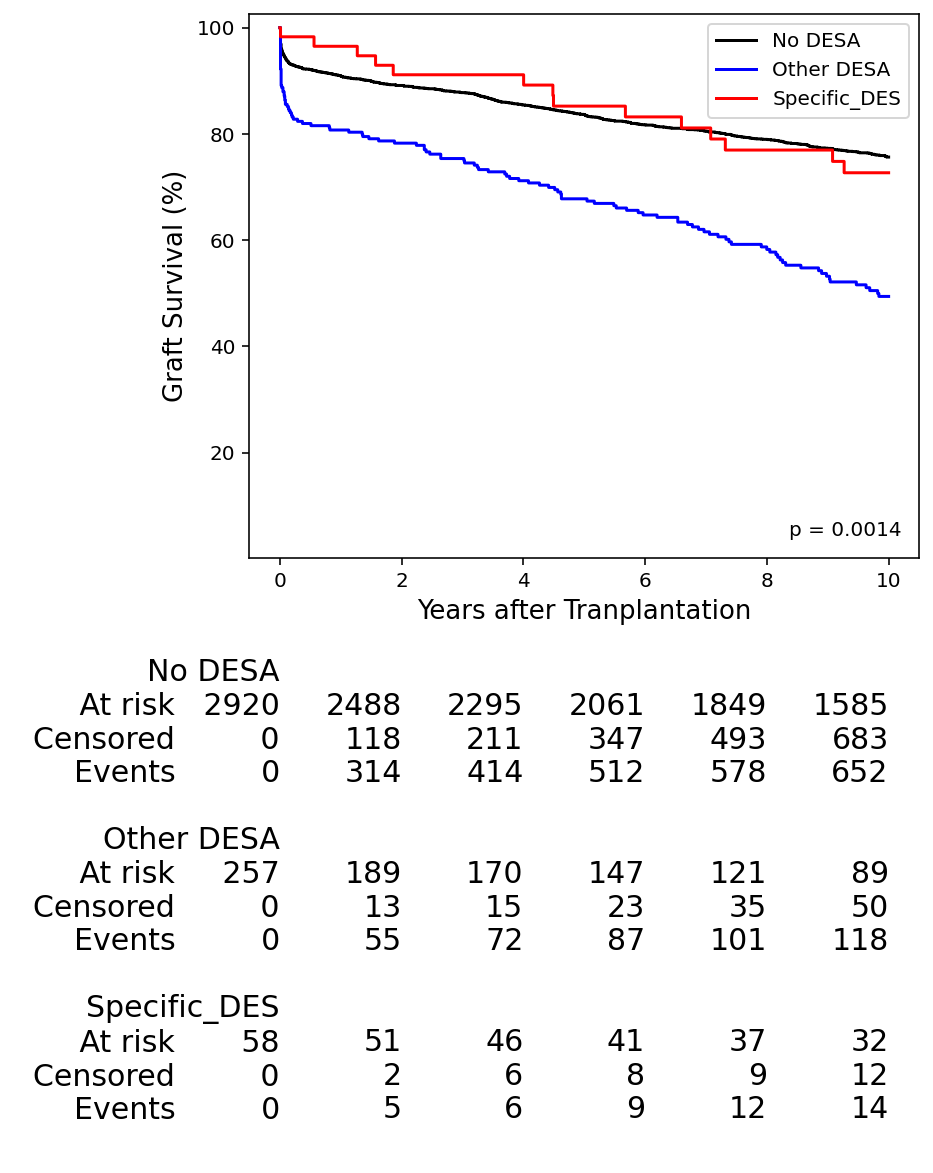

In [62]:
df_dead = df[df.TypeOfDonor_NOTR == 'Deceased']

# relevant_desa =  ['71TD', '144QL', '70DRA', '80TLR', '76ED', '70DA', '45EV', '67F', '76ET', '163RG', '67VG', '150AAH', '158T', '62QE', '45GV', '45KE', '71A', '66NH', '80TA', '114R', '44KM']
# relevant_desa =  ['71TD', '144QL', '70DRA', '80TLR', '76ED', '70DA', '45EV', '67F', '76ET', '163RG', '67VG']
relevant_desa = ['163RW', '37FL', '173K', '152RA', '80I', '193PL', '71ATD', '152A', '267QE']
plot_km_curve(df_dead, donor_type='Deceased', ep=relevant_desa, adjust=False)



In [45]:
old_rel_desa & set(relevant_desa)

NameError: name 'old_rel_desa' is not defined

# Validation

Top curve: 51.51, Lower curve: 46.67
10-Year Gap is:  4.85
1-Year Gap is:  8.27


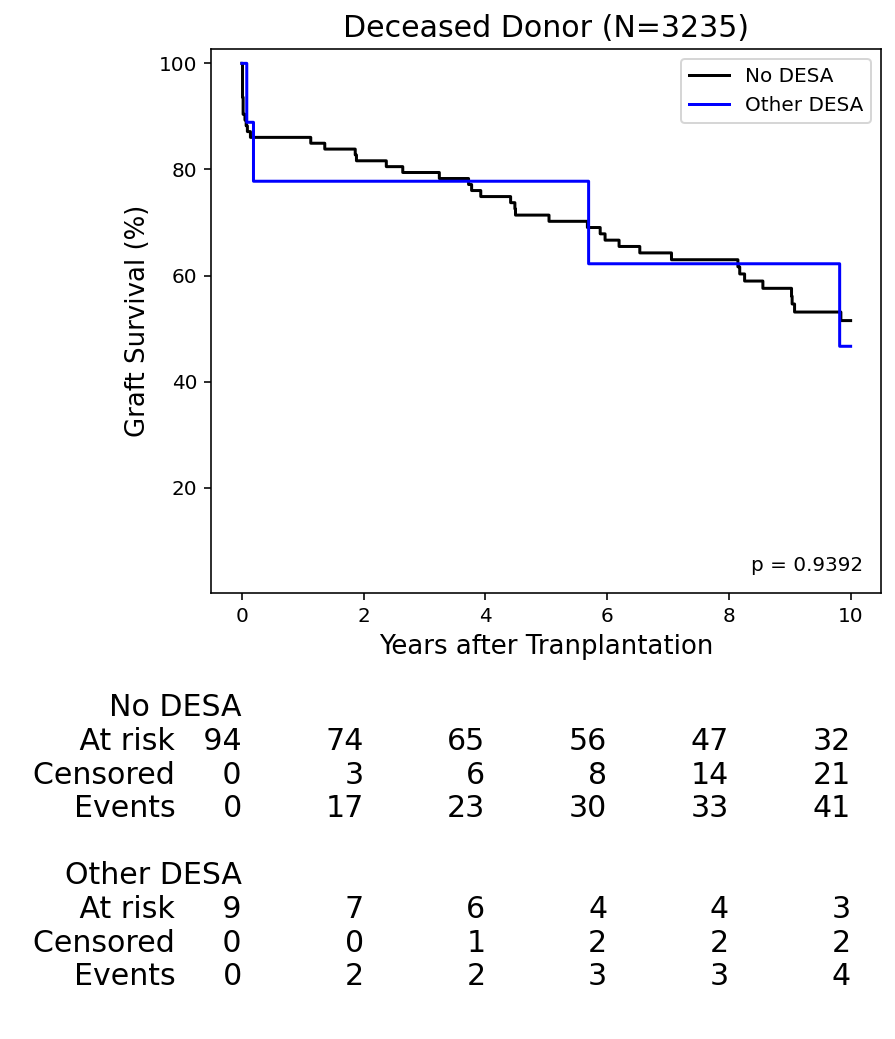

In [108]:

plot_km_curve(df_val, donor_type='Deceased', ep=relevant_desa, adjust=False)

In [123]:
df_living = df[df.TypeOfDonor_NOTR == 'Living']
plot_km_curve(df_living, donor_type='Living', ep=relevant_desa, adjust=False)

ValueError: zero-size array to reduction operation maximum which has no identity